# 3. Neural Networks + Text Mining (Modern ML / Enrichment)

Data loading and prep

In [13]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from wordcloud import WordCloud

# Scikit-Learn Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, LassoCV,
    Ridge, RidgeCV,
)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configuration
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/student-por.csv')

print(f"Sample size: {df.shape[0]} students, {df.shape[1]} variables")
print(f"\nVariable types:\n{df.dtypes.value_counts().to_string()}")

missing = df.isnull().sum()
print(f"\nMissing values: {'None' if missing.sum() == 0 else missing[missing > 0]}")

df.head()

Sample size: 649 students, 33 variables

Variable types:
object    17
int64     16

Missing values: None


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## part 1: text mining

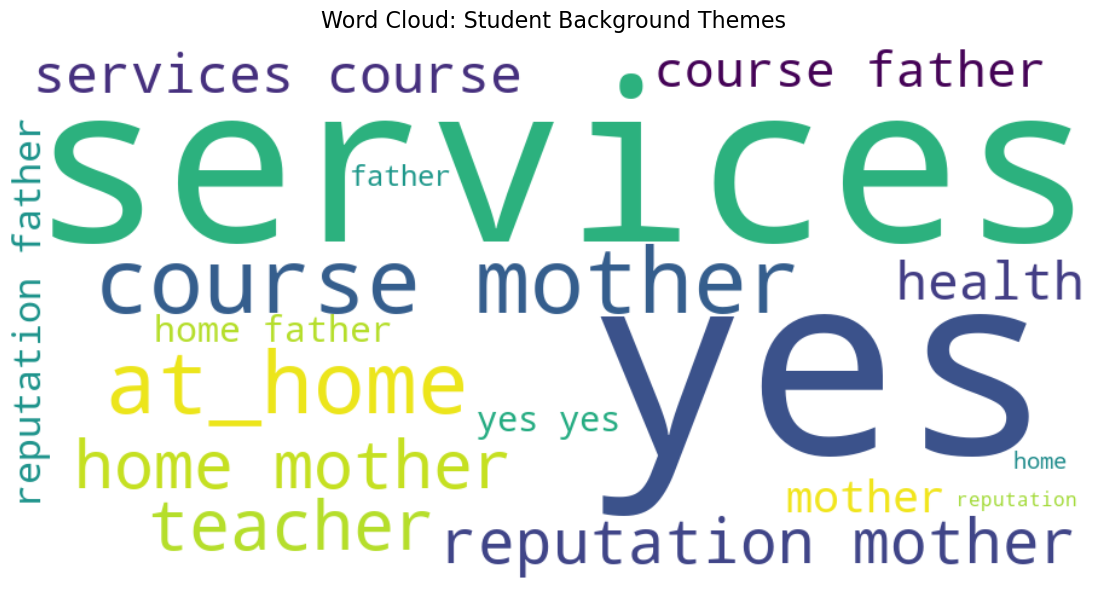

In [10]:
# verify columns exist in the dataframe to avoid errors
possible_cols = ['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'activities']
text_cols = [c for c in possible_cols if c in df.columns]

# We convert to string first to ensure no errors with non-text data
text_data = " ".join(
    df[text_cols]
    .astype(str)
    .apply(lambda row: " ".join(row.values), axis=1)
    .tolist()
)

# Generate  Word Cloud
wordcloud = WordCloud(width=900, height=450, background_color="white", colormap='viridis').generate(text_data)

# plot and save graphs
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Student Background Themes", fontsize=16)
plt.tight_layout()
plt.savefig("graphs/word_cloud.png", bbox_inches="tight", dpi=200)
plt.show()

## part 2: neural networks

In [15]:
# Create Binary Target (Pass = G3 >= 10)
df['passed'] = (df['G3'] >= 10).astype(int)

# fdefine x and y and drop unnecessary columns
drop_cols = ['G3', 'passed', 'G1', 'G2']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['passed']

# define Preprocessing Pipeline
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]) 

# stratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# apply Transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# train Neural Network 
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                         activation='relu', 
                         max_iter=1000, 
                         random_state=42, 
                         early_stopping=True)
nn_model.fit(X_train_scaled, y_train)

# train Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# evaluate and compare

nn_pred = nn_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test_scaled)

nn_acc = accuracy_score(y_test, nn_pred)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(f"Decision Tree Accuracy:  {dt_acc:.4f}")

Neural Network Accuracy: 0.8462
Decision Tree Accuracy:  0.7538
